In [40]:
from google.colab import drive
drive.mount('/content/drive')

import os

if not os.path.isdir('drive/MyDrive/datasets/API Datasets/wto1'): #if folder 'datasets' doesn't exist
  os.makedirs('drive/MyDrive/datasets/API Datasets/wto1') #make folder
os.getcwd() #this asks: where am I? Will return filepath (to check)

import pandas as pd
import requests


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:

########### Python 3.2 #############
import http.client, urllib.request, urllib.parse, urllib.error, base64
import json

#First, we will use the API key to access the WTO data

#for year:
  #for country:
headers = {
    # Request headers
    'Ocp-Apim-Subscription-Key': '1423880037a24ebe97540ff091e6e7bc',
}

#This describes data we're grabbing from WT
print("First, grab your data. We're specifying the data as all countries' Bilateral Imports (based on HS codes) of sheep from the world, in the year 1998. ")
params = urllib.parse.urlencode({
    # Request parameters.
    'i': 'HS_M_0010', #Bilateral imports by detailed HS codes (2,4,6 digit) [HS_M_0010]
    'r': 'all',
    'p': '000', #partner = World, aka sum of all exports
    'ps': '1998', #in the year 1998
    'pc': '010410',
    'spc': 'false',
    'fmt': 'json',
    'mode': 'full',
    'dec': 'default',
    'off': '0',
    'max': '500', #maximum 500 results
    'head': 'H',
    'lang': '1',
    'meta': 'false',
})


#now we try to request some data, the timeseries data, through the API
try:
    conn = http.client.HTTPSConnection('api.wto.org')
    conn.request("GET", "/timeseries/v1/data?%s" % params, "", headers)
    response = conn.getresponse()
    data = response.read()
    print(data)
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))


####################################




First, grab your data. We're specifying the data as all countries' Bilateral Imports (based on HS codes) of sheep from the world, in the year 1998. 
b'{\r\n  "Dataset": [{"IndicatorCategoryCode":"TPM_HS","IndicatorCategory":"Bilateral imports","IndicatorCode":"HS_M_0010","Indicator":"Bilateral imports by detailed HS codes (2,4,6 digit)","ReportingEconomyCode":"076","ReportingEconomy":"Brazil","PartnerEconomyCode":"000","PartnerEconomy":"World","ProductOrSectorClassificationCode":"HS","ProductOrSectorClassification":"Harmonized System","ProductOrSectorCode":"010410","ProductOrSector":"Sheep","PeriodCode":"A","Period":"Annual","FrequencyCode":"A","Frequency":"Annual","UnitCode":"USD","Unit":"US$","Year":1998,"ValueFlagCode":null,"ValueFlag":null,"TextValue":null,"Value":3138524.0},{"IndicatorCategoryCode":"TPM_HS","IndicatorCategory":"Bilateral imports","IndicatorCode":"HS_M_0010","Indicator":"Bilateral imports by detailed HS codes (2,4,6 digit)","ReportingEconomyCode":"862","ReportingEc

In [100]:
from socket import AF_ALG
df = pd.DataFrame(columns=['country', 'year', 'partnerCountry', 'item', 'quantity', 'units'])
df



,country,year,partnerCountry,item,quantity,units


In [ ]:
 #This calls all data from 1998 for sheep imports, for each country, and puts it into a formatted string
import json
str1 = data.decode('ISO-8859-1') #interpret the binary data and convert it into a Unicode string.
str1 = "\r"+str1
str1


In [109]:
#turns the string into a list of dictionaries, so the data is referenceable

json1 = json.loads(str1)
print(type(json1))  #checks if it turned into a dictionary

<class 'dict'>


In [110]:
#Investigate the formatting of the dictionary:
keys_list = json1.keys() #double check what the keys are in my dictionary
print(keys_list) #now we see that the dictionary is nested

#make function to reveal the formatting of the nested keys in my dictionary, so we can reference them
def print_nested_keys(d, prefix=''):
    for key, value in d.items():
        if isinstance(value, dict):  # Check if the value is another dictionary
            print_nested_keys(value, prefix + key + '.')  # Recursively call the function for nested dictionaries
        else:
            print(prefix + key)  # Print the key with the prefix

# Assuming json1 is your nested dictionary
print_nested_keys(json1)


dict_keys(['Dataset'])
Dataset


In [111]:
#From this, we see that there is only one key, they're not nested, and that the JSON list is keyed by integer value of each entry, not by name

# Accessing the list of dictionaries under 'Dataset'
dataset = json1['Dataset']

# Accessing the first dictionary in the list
first_entry = dataset[0]
print(first_entry)

# Accessing the second dictionary in the list
second_entry = dataset[1]
print(second_entry)

# ... and so on

{'IndicatorCategoryCode': 'TPM_HS', 'IndicatorCategory': 'Bilateral imports', 'IndicatorCode': 'HS_M_0010', 'Indicator': 'Bilateral imports by detailed HS codes (2,4,6 digit)', 'ReportingEconomyCode': '076', 'ReportingEconomy': 'Brazil', 'PartnerEconomyCode': '000', 'PartnerEconomy': 'World', 'ProductOrSectorClassificationCode': 'HS', 'ProductOrSectorClassification': 'Harmonized System', 'ProductOrSectorCode': '010410', 'ProductOrSector': 'Sheep', 'PeriodCode': 'A', 'Period': 'Annual', 'FrequencyCode': 'A', 'Frequency': 'Annual', 'UnitCode': 'USD', 'Unit': 'US$', 'Year': 1998, 'ValueFlagCode': None, 'ValueFlag': None, 'TextValue': None, 'Value': 3138524.0}
{'IndicatorCategoryCode': 'TPM_HS', 'IndicatorCategory': 'Bilateral imports', 'IndicatorCode': 'HS_M_0010', 'Indicator': 'Bilateral imports by detailed HS codes (2,4,6 digit)', 'ReportingEconomyCode': '862', 'ReportingEconomy': 'Venezuela, Bolivarian Republic of', 'PartnerEconomyCode': '000', 'PartnerEconomy': 'World', 'ProductOrSect

In [113]:
#define a function that allows you to find a specific metric based on the name of the country, rather than the index
def find_country_data(country_name):
    for data in dataset:
        reporting_economy = data.get('ReportingEconomy')
        if reporting_economy is not None and reporting_economy.lower() == country_name.lower().strip():
            return data
    return None  # Return None if the country is not found

# If necessary test: Print the entire dataset to inspect its contents
#for data in dataset:
#  print(data)

#Test: Accessing data for 'Suriname' using the find_country_data function
brz_data = find_country_data('Brazil')
print(brz_data)

{'IndicatorCategoryCode': 'TPM_HS', 'IndicatorCategory': 'Bilateral imports', 'IndicatorCode': 'HS_M_0010', 'Indicator': 'Bilateral imports by detailed HS codes (2,4,6 digit)', 'ReportingEconomyCode': '076', 'ReportingEconomy': 'Brazil', 'PartnerEconomyCode': '000', 'PartnerEconomy': 'World', 'ProductOrSectorClassificationCode': 'HS', 'ProductOrSectorClassification': 'Harmonized System', 'ProductOrSectorCode': '010410', 'ProductOrSector': 'Sheep', 'PeriodCode': 'A', 'Period': 'Annual', 'FrequencyCode': 'A', 'Frequency': 'Annual', 'UnitCode': 'USD', 'Unit': 'US$', 'Year': 1998, 'ValueFlagCode': None, 'ValueFlag': None, 'TextValue': None, 'Value': 3138524.0}


In [114]:
#Create ways to reference, analyze and visualize the data
import matplotlib.pyplot as plt #chart package
import PIL #image creating/draw package

In [ ]:

#This will create a dataframe that has each country, the specified metrics, and a color based on the ProductOrSector
for i, country in enumerate(json1["Dataset"]):
    country1 = (country["ReportingEconomy"])
    year = (country["Year"])
    partnerCountry = (country["PartnerEconomy"])
    item = (country["ProductOrSector"])
    quantity = (country["Value"])
    units = (country["Unit"])
    quantity = int(quantity)
    color = "white"
    if item == "Agricultural product":
      color = "yellow"
    elif item == "Food":
      color = "red"
    elif item == "Fuels and mining products":
      color = "blue"
    elif item == "Chemicals":
      color = "purple"
    elif item == "Manufactures":
      color = "green"
    elif item == "Textiles":
      color = "grey"
    elif item == "Clothing":
      color = "orange"
    #if quantity > 0:
    #  q1 = quantity / 10
    #  q2 = i * 2
    #  draw = ImageDraw.Draw(im2)
    #  draw.ellipse((q1, i, quantity, q2), fill = color, outline ='black')
    df = df.append({'country': country1, 'year': year, 'partnerCountry': partnerCountry, 'item': item, 'quantity': quantity,'units': units}, ignore_index=True)
print(df)


#partner countries = 004, 008, 0012...
#so that's all the countries
#i can't tell with the exporters tbh

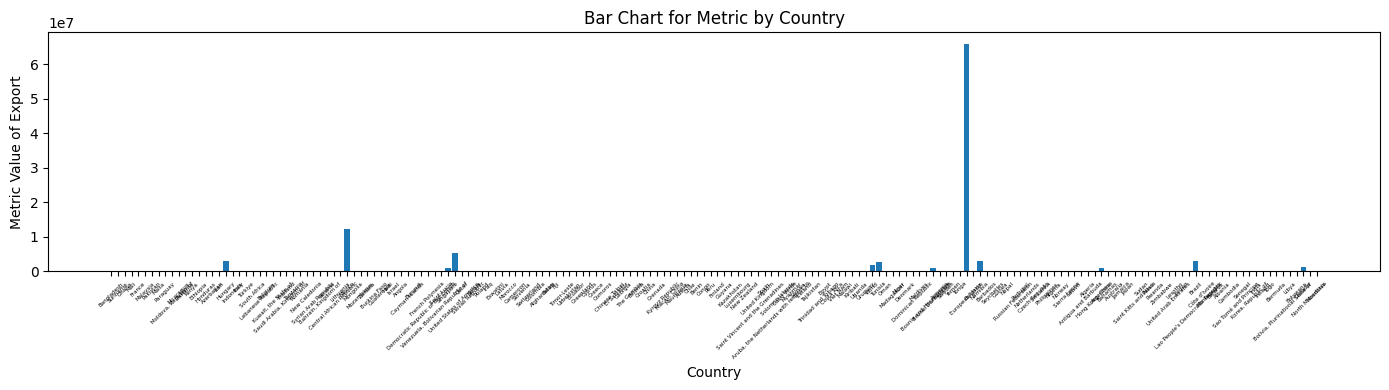

In [117]:
# Plot the bar chart

bar_df = pd.DataFrame({
    'country': df['country'],
    'quantity': df['quantity'],
    'partnerCountry': df['partnerCountry']
})

# Drop rows where 'quantity' is equal to 0
bar_df = bar_df[bar_df['quantity'] != 0]


plt.figure(figsize=(14, 4))  # Adjust the figure size as needed

bars = plt.bar(bar_df['country'], bar_df['quantity'])

plt.xlabel('Country')
plt.ylabel('Metric Value of Export')
plt.title('Bar Chart for Metric by Country')

# Rotate the country names and resize if needed for better visibility
plt.xticks(rotation=45, fontsize=4)# Set the desired font size for x-axis tick labels

# Add data labels to the bars with custom font size
#font_size_labels = 12  # Set the font size for the data labels
#for bar in bars:
#    height = bar.get_height()
#    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=font_size_labels)


# Show the plot
plt.tight_layout()  # To ensure all labels are displayed properly
plt.savefig('1998_Sheep_Imports.png', dpi=600)
plt.show()




---

